In [1]:
!pip install mlxtend

You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#from google.colab import auth
import os
import pandas as pd

#new
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.0f}'.format

#auth.authenticate_user()
#os.chdir('/content/dataset/')

df = pd.read_csv('Supermarket.csv')
print(df.shape)
df.head()

conn = sql.connect("supermarket.db")
df.to_sql("table1", conn, if_exists='replace')
sql_string = "select * from table1"
df = pd.read_sql(sql_string, conn)
df.head()
df.shape

sql ='''
SELECT CUST_CODE, 
SUM(SPEND) AS TOTAL_SALES, 
COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT 
FROM 'table1'
WHERE CUST_CODE IS NOT NULL 
GROUP BY CUST_CODE
'''

df = pd.read_sql(sql, conn)
print(df.head())

df.to_csv (r'cust_segment.csv', index = False, header=True)

<H1> Prepare Data </H1>

In [3]:
df = pd.read_csv('BreadBasket_DMS.csv')
print(df)

             Date      Time  Transaction           Item
0      2016-10-30  09:58:11            1          Bread
1      2016-10-30  10:05:34            2   Scandinavian
2      2016-10-30  10:05:34            2   Scandinavian
3      2016-10-30  10:07:57            3  Hot chocolate
4      2016-10-30  10:07:57            3            Jam
...           ...       ...          ...            ...
21288  2017-04-09  14:32:58         9682         Coffee
21289  2017-04-09  14:32:58         9682            Tea
21290  2017-04-09  14:57:06         9683         Coffee
21291  2017-04-09  14:57:06         9683         Pastry
21292  2017-04-09  15:04:24         9684      Smoothies

[21293 rows x 4 columns]


<H1> Check missing data

In [4]:
missing = df.isnull().sum()
print(missing)

Date           0
Time           0
Transaction    0
Item           0
dtype: int64


<H1>List unique items sold

In [5]:
df.Item.unique()


array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'NONE',
       'Tartine', 'Basket', 'Mineral water', 'Farm House', 'Fudge',
       'Juice', "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pi

<H1> Cleansing NONE items

In [6]:
df.loc[df["Item"]=='NONE'].shape[0]
df = df[df["Item"] != 'NONE']

<H1> Plot top 10 products

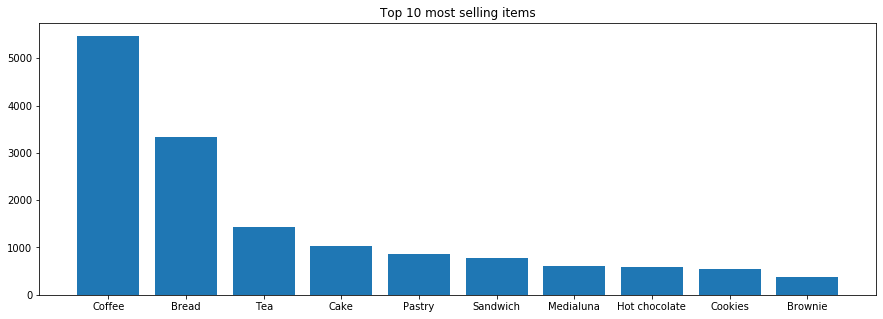

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

df_for_top10_Items = df['Item'].value_counts().head(10)
Item_array= np.arange(len(df_for_top10_Items))

plt.figure(figsize=(15,5))
Items_name= df_for_top10_Items.index.values.tolist()
plt.bar(Item_array,df_for_top10_Items.iloc[:])
plt.xticks(Item_array,Items_name)
plt.title('Top 10 most selling items')
plt.show()

<H1> Prepare data for Apriori using one-hot encoding

In [8]:
hot_encoded_df=df.groupby(['Transaction','Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
#print(hot_encoded_df[hot_encoded_df['Adjustment']!=0])

<H1> Turn float into integer

In [9]:
def encode_units(x):
    if x <= 0:
        return 0.0
    if x >= 1:
        return 1.0
hot_encoded_df = hot_encoded_df.applymap(encode_units)

<H1> Determine product association using apriori

In [10]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(hot_encoded_df, min_support=0.01, use_colnames=True)
print(frequent_itemsets)

    support                 itemsets
0         0              (Alfajores)
1         0               (Baguette)
2         0                  (Bread)
3         0                (Brownie)
4         0                   (Cake)
..      ...                      ...
56        0          (Coffee, Toast)
57        0          (Tea, Sandwich)
58        0    (Coffee, Bread, Cake)
59        0  (Coffee, Bread, Pastry)
60        0      (Tea, Cake, Coffee)

[61 rows x 2 columns]


<H1>List out rules

In [21]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
72,(Cake),"(Tea, Coffee)",0,0,0,0,2,0,1
69,"(Tea, Coffee)",(Cake),0,0,0,0,2,0,1
27,(Hot chocolate),(Cake),0,0,0,0,2,0,1
26,(Cake),(Hot chocolate),0,0,0,0,2,0,1
28,(Tea),(Cake),0,0,0,0,2,0,1
29,(Cake),(Tea),0,0,0,0,2,0,1
53,(Toast),(Coffee),0,0,0,1,1,0,2
52,(Coffee),(Toast),0,0,0,0,1,0,1
67,(Pastry),"(Coffee, Bread)",0,0,0,0,1,0,1
62,"(Coffee, Bread)",(Pastry),0,0,0,0,1,0,1


<H1> In-class

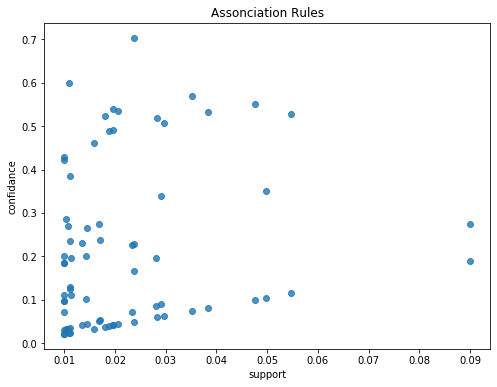

In [23]:
import seaborn as sns
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(8,6))    
plt.title('Assonciation Rules')
plt.xlabel('support')
plt.ylabel('confidance')
sns.regplot(x=support, y=confidence, fit_reg=False)
plt.show()

<H1>Filter rules

In [28]:
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.5) ]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
53,(Toast),(Coffee),0,0,0,1,1,0,2
49,(Spanish Brunch),(Coffee),0,0,0,1,1,0,1
37,(Medialuna),(Coffee),0,0,0,1,1,0,1
41,(Pastry),(Coffee),0,0,0,1,1,0,1
3,(Alfajores),(Coffee),0,0,0,1,1,0,1
35,(Juice),(Coffee),0,0,0,1,1,0,1
43,(Sandwich),(Coffee),0,0,0,1,1,0,1
25,(Cake),(Coffee),0,0,0,1,1,0,1
45,(Scone),(Coffee),0,0,0,1,1,0,1
31,(Cookies),(Coffee),0,0,0,1,1,0,1


<H1> Visualize rules

In [14]:
!pip install pygraphviz

You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


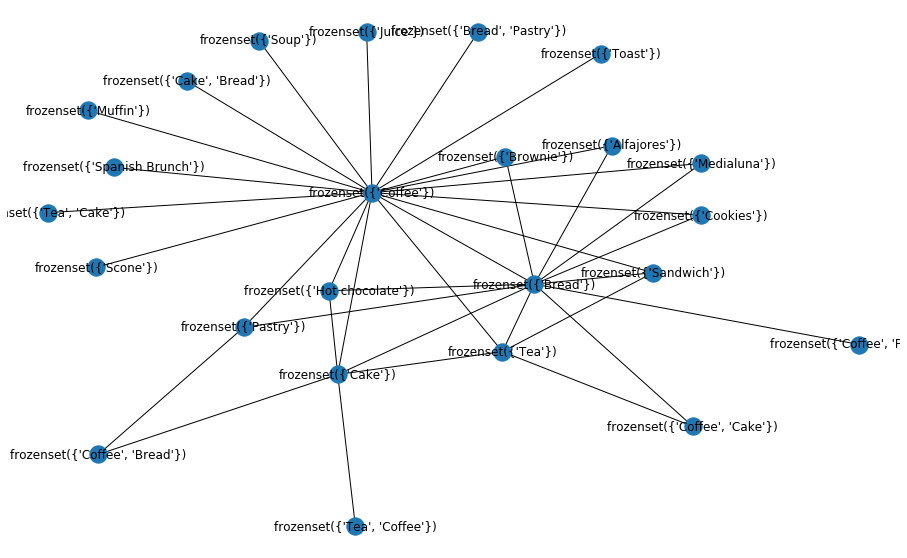

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax = plt.subplots(figsize=(16,10))
G = nx.from_pandas_edgelist(rules, source='antecedents',target='consequents')
pos=nx.nx_agraph.graphviz_layout(G)

nx.draw(G,pos, with_labels=True)
plt.show()


<H1> Prepare data

In [44]:
item_item_matrix = pd.DataFrame(index=hot_encoded_df.columns,columns=hot_encoded_df.columns)
#print(item_item_matrix)

In [45]:
from scipy.spatial.distance import cosine

for i in range(0,len(item_item_matrix.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(item_item_matrix.columns)) :
      # Fill in placeholder with cosine similarities
      item_item_matrix.iloc[i,j] = 1 - cosine(hot_encoded_df.iloc[:,i],hot_encoded_df.iloc[:,j])

#print(item_item_matrix)

In [46]:
links = item_item_matrix.rename_axis('related item', 
                                     axis='columns').stack().reset_index()
links.columns = ['item', 'related item','value']


In [47]:
links_filtered=links.loc[ (links['value'] > 0.1) & 
                         (links['item'] != links['related item']) ]


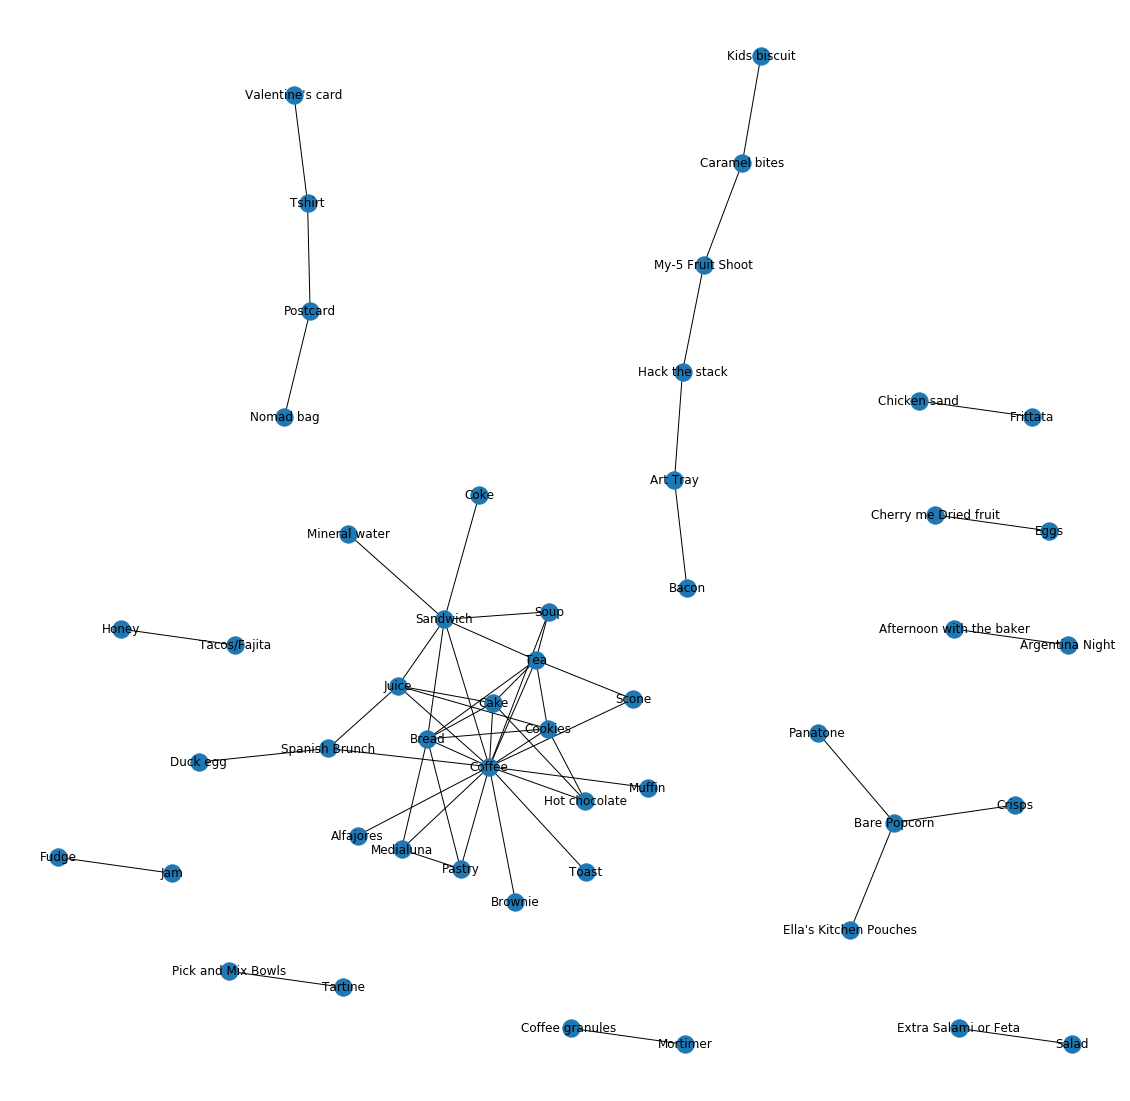

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax=plt.subplots(figsize=(20,20))
G = nx.from_pandas_edgelist(links_filtered,source='item',target='related item')
pos=nx.nx_agraph.graphviz_layout(G)
nx.draw(G,pos,with_labels=True)
plt.show()
